# Part (a) *Simulation Function*
Each node is defined as:
- Pre-activation: $a_i = \sum_j w_{ij} z_j$
- Activation: $z_i = f_i(a_i)$

The activation functions are:

- $f_1(x) = f_3(x) = f_4(x) = \sigma(x) = \dfrac{1}{1+e^{-x}}$
- $f_2(x) = \text{ReLU}(x) = \max(0, x)$
- $f_5(x) = x$ 

*($f_5(x)$ wasn't explicitly stated in the assignemnt, so my assumption is it's just an $\text{Identity(x)}$ activation function)*

### Implementation Notes
- The network is represented by a **5×5 weight matrix** $B$, where $B[i, j] = w_{ij}$ if there is a connection from node $j$ to node $i$, otherwise 0.
  
- The `forward_pass(x, weights)` function:
  - Takes scalar input $x$ at node 1,
  - Computes all $a_i$ and $z_i$,
  - Returns a dictionary with the values of `a`, `z`, and `B`.

### Example Output
To verify correctness, I included an arbitrary, hard-coded example using specific edge weights with input $x=0.8$. This is just for testing that the `forward_pass` function works as intended.


In [9]:
import math
from typing import Dict, Tuple, List

Idx = int                # node index in {1,2,3,4,5}
Edge = Tuple[Idx, Idx]   # (to_i, from_j)

def sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-x))

def relu(x: float) -> float:
    return x if x > 0.0 else 0.0

def build_B(weights: Dict[Edge, float]) -> List[List[float]]:
    """
    Build the 5x5 weight matrix B with B[i-1][j-1] = w_j^i if edge j->i exists, else 0.
    Nodes are 1-indexed in the math, 0-indexed in the Python lists.
    """
    B = [[0.0 for _ in range(5)] for _ in range(5)]
    for (i, j), w in weights.items():
        B[i-1][j-1] = float(w)
    return B

def forward_pass(x: float, weights: Dict[Edge, float]):
    """
    x is the scalar input fed at node 1: a1 = x, z1 = sigmoid(a1).
    weights maps (to_i, from_j) -> value for each existing edge j -> i.
    Returns:
      - 'a': [a1,...,a5]
      - 'z': [z1,...,z5]
      - 'B': 5x5 weight matrix as a list of lists
    """
    B = build_B(weights)

    a = [0.0]*5
    z = [0.0]*5

    # Node 1 (input then sigmoid)
    a[0] = float(x)
    z[0] = sigmoid(a[0])     # f1 = sigmoid

    # Helper to compute ai = sum_j B[i][j] * z[j]
    def preact(i: int) -> float:
        return sum(B[i][j] * z[j] for j in range(5))

    # Node 2 (ReLU)
    a[1] = preact(1)
    z[1] = relu(a[1])        # f2 = ReLU

    # Node 3 (sigmoid)
    a[2] = preact(2)
    z[2] = sigmoid(a[2])     # f3 = sigmoid

    # Node 4 (sigmoid)
    a[3] = preact(3)
    z[3] = sigmoid(a[3])     # f4 = sigmoid

    # Node 5 (identity output)
    a[4] = preact(4)
    z[4] = a[4]              # z5 = a5

    return {"a": a, "z": z, "B": B}


In [ ]:
# Arbitrary weights for testing: 
# a = arbitrary weight matrix a 
weights = {
    (2,1): 0.7,   # a1 -> a2
    (3,1): -0.4,  # a1 -> a3
    (4,1): 0.2,   # a1 -> a4
    (3,2): 0.9,   # a2 -> a3
    (4,2): -1.1,  # a2 -> a4
    (5,2): 0.5,   # a2 -> a5
    (5,3): 1.2,   # a3 -> a5
    (5,4): -0.3,  # a4 -> a5
}

# Execution of forward_pass with input 0.8:
out = forward_pass(0.8, weights)

# Formatted response so it's readable:
for i, (a_val, z_val) in enumerate(zip(out["a"], out["z"]), start=1):
    print(f"a{i} = {a_val:.4f}, z{i} = {z_val:.4f}")

print("\nWeight matrix B:")
for row in out["B"]:
    print(" ".join(f"{val:6.2f}" for val in row))

a1 = 0.8000, z1 = 0.6900
a2 = 0.4830, z2 = 0.4830
a3 = 0.1587, z3 = 0.5396
a4 = -0.3933, z4 = 0.4029
a5 = 0.7681, z5 = 0.7681

Weight matrix B:
  0.00   0.00   0.00   0.00   0.00
  0.70   0.00   0.00   0.00   0.00
 -0.40   0.90   0.00   0.00   0.00
  0.20  -1.10   0.00   0.00   0.00
  0.00   0.50   1.20  -0.30   0.00


# Part (b) *Derivation of Error Terms*

Using mean squared error: $L=\tfrac12 (z_5 - y)^2$, let $\delta_i = \dfrac{\partial L}{\partial a_i}$.

Output node (node 5):
$
\delta_5
= \frac{\partial L}{\partial z_5}\cdot \frac{\partial z_5}{\partial a_5}
= (z_5 - y)\, f_5'(a_5).
$

Since $f_5(x)=x$ (identity), $f_5'(a_5)=1$, so $\boxed{\delta_5 = z_5 - y}$.

Hidden node $i\in\{1,2,3,4\}$: by chain rule,
$
\delta_i
= \frac{\partial L}{\partial a_i}
= f_i'(a_i)\sum_{k} w_i^{\,k}\,\delta_k,
$
where the sum is over all *children* $k$ of $i$ (i.e., edges $i\!\to\!k$), and $w_i^{\,k}$ is the weight on edge $i\!\to\!k$.

**Derivatives of the activations:**
- If $f=\sigma$ (sigmoid): $f'(a) = \sigma(a)\bigl(1-\sigma(a)\bigr) = z(1-z)$.
- If $f=\text{ReLU}$: $f'(a) = \mathbf{1}[a>0]$ (we take 0 at $a=0$).
- If $f=\text{Identity}$: $f'(a)=1$.

Compute $\delta$ in **reverse topological order**: $5 \to 4 \to 3 \to 2 \to 1$.

### Implementation Notes
- I already store weights as a dict $(\text{to},\text{from})\mapsto w$. For the hidden-node sum $\sum_k w_i^{\,k}\delta_k$, I gather outgoing edges of $i$, i.e., all pairs $(k,i)$ in the weights.
- The function `backward_pass(a, z, y, weights)` returns a list $[\delta_1,\dots,\delta_5]$.

### Example Output
To verify correctness, I included the same arbitrary, hard-coded weights from Part a. This is just for testing that the `forward_pass` function works as intended.

In [7]:
def sigmoid_prime_from_z(z: float) -> float:
    # derivative of sigmoid using z = sigmoid(a): z * (1 - z)
    return z * (1.0 - z)

def relu_prime_from_a(a: float) -> float:
    # derivative of ReLU using a
    return 1.0 if a > 0.0 else 0.0  # at a=0, choose 0

def backward_pass(a_values, z_values, y_true: float, weights: Dict[Edge, float]):
    """
    Compute deltas δi = dL/da_i for i=1..5.
    - a_values, z_values: lists from forward_pass (len==5)
    - y_true: scalar target
    - weights: dict[(to_i, from_j)] = weight, as in forward_pass
    Returns: list of deltas [δ1, δ2, δ3, δ4, δ5]
    """
    a = a_values
    z = z_values
    d = [0.0]*5  # deltas

    # helper: sum_k w_i^k * δk for node i (outgoing edges from i)
    def down_sum(i_node_1idx: int) -> float:
        s = 0.0
        for (to_i, from_j), w in weights.items():
            if from_j == i_node_1idx:
                s += float(w) * d[to_i - 1]  # note: d index is 0-based
        return s

    # node 5 (identity)
    d[4] = z[4] - y_true

    # node 4 (sigmoid)
    d[3] = sigmoid_prime_from_z(z[3]) * down_sum(4)

    # node 3 (sigmoid)
    d[2] = sigmoid_prime_from_z(z[2]) * down_sum(3)

    # node 2 (ReLU)
    d[1] = relu_prime_from_a(a[1]) * down_sum(2)

    # node 1 (sigmoid)
    d[0] = sigmoid_prime_from_z(z[0]) * down_sum(1)

    return d

In [ ]:
# Same test weights from Part a
weights = {
    # a = arbitrary weight matrix a 
    (2,1): 0.7,    # a1 -> a2
    (3,1): -0.4,   # a1 -> a3
    (4,1): 0.2,    # a1 -> a4
    (3,2): 0.9,    # a2 -> a3
    (4,2): -1.1,   # a2 -> a4
    (5,2): 0.5,    # a2 -> a5
    (5,3): 1.2,    # a3 -> a5
    (5,4): -0.3,   # a4 -> a5
}

# Forward with input x = 0.8
out = forward_pass(0.8, weights)
a, z = out["a"], out["z"]

# Backward with target y = 0.5
deltas = backward_pass(a, z, y_true=0.5, weights=weights)

# Formatted response so it's readable:
for i, di in enumerate(deltas, start=1):
    print(f"d{i} = {di: .5f}")


d1 =  0.02637
d2 =  0.22729
d3 =  0.07993
d4 = -0.01935
d5 =  0.26812


# Part (c) *Sample Calculations*

Part c is basically just adjusting the arbitrary values I assigned in the example outputs of Part a and b to ensure accuracy. So all I've done is just replace the hard-coded values with the ones from the assignment and repeated the behavior of the example output scripts from Parts a and b. The only addition is that in this case, we run two samples.

In [ ]:
# fixed weights from the assignment
weights_c = {
    # B = weight matrix B 
    (2,1): 3,    # B1 -> B2
    (3,1): -4,   # B1 -> B3
    (4,1): -1,   # B1 -> B4
    (3,2): 1,    # B2 -> B3
    (4,2): -3,   # B2 -> B4
    (5,3): 2,    # B3 -> B5
    (5,4): -10,  # B4 -> B5
}

def run_sample(x, y):
    out = forward_pass(x, weights_c)
    a, z = out["a"], out["z"]
    d = backward_pass(a, z, y_true=y, weights=weights_c)

    # Formatted response so it's readable:
    print(f"\nSample: x={x:.1f}, y={y:.1f}")
    print("z:", ", ".join(f"{v:.6f}" for v in z))
    print("δ:", ", ".join(f"{v:.6f}" for v in d))

# sample 1
run_sample(0.0, 0.5)

# sample 2
run_sample(1.0, 0.1)



Sample: x=0.0, y=0.5
z: 0.500000, 1.500000, 0.377541, 0.006693, 0.688153
δ: 0.009163, 0.125959, 0.088433, -0.012509, 0.188153

Sample: x=1.0, y=0.1
z: 0.731059, 2.193176, 0.324962, 0.000668, 0.643245
δ: -0.039730, 0.249214, 0.238335, -0.003626, 0.543245


# Part (d) *SGD Training Function*

Train the network with **stochastic gradient descent (SGD)** using the loss $L(x,y)=\tfrac12\,(z_5 - y)^2$, where $z_5$ is the model output for input $x$.

From backprop (Part b), the error terms are: $ \delta_5 = z_5 - y,\qquad \delta_i = f_i'(a_i)\sum_{k} w_i^{\,k}\,\delta_k \ \ (i\in\{1,2,3,4\}).$

The gradient for each weight on edge $j\!\to\! i$ is $\frac{\partial L}{\partial w_j^{\,i}} = \delta_i \, z_j$, so a standard SGD update with learning rate $\eta$ is $w_j^{\,i} \leftarrow w_j^{\,i} - \eta\;\delta_i \, z_j$.

**Script Logic (SGD):**
1. For each epoch:
2. For each training sample $(x,y)$:
   - Run `forward_pass(x, weights)` to get $a,z$.
   - Run `backward_pass(a, z, y, weights)` to get $\delta$.
   - For every existing edge $(j\!\to\! i)$: $w_j^{\,i} \leftarrow w_j^{\,i} - \eta\; \delta_i \, z_j$.
3. Return the trained weights.

We represent weights as a dictionary `weights[(to_i, from_j)] = value` and reuse the
`forward_pass` and `backward_pass` from parts (a)–(b).

*I decided to skip another Example Output section because I realize that's the purpose of Part e.*


In [12]:
def train_sgd(samples, weights: Dict[Edge, float], learning_rate: float, epochs: int):
    """
    SGD:
      for epoch in range(epochs):
        for (x, y) in samples:
          a,z = forward_pass(x, weights)
          d   = backward_pass(a, z, y, weights)
          for each edge (to_i, from_j): w <- w - lr * d[to_i-1] * z[from_j-1]
          
    Returns the (mutated) weights dict.
    """
    for _ in range(epochs):
        for x, y in samples:
            out = forward_pass(x, weights)
            a, z = out["a"], out["z"]
            d = backward_pass(a, z, y_true=y, weights=weights)
            for (to_i, from_j), w in list(weights.items()):
                weights[(to_i, from_j)] = w - learning_rate * d[to_i - 1] * z[from_j - 1]
    return weights


# Part (e) *Training Results*

Similarly to Part c, this is just implementing the script from Part d; with the addition of plotting the results. 

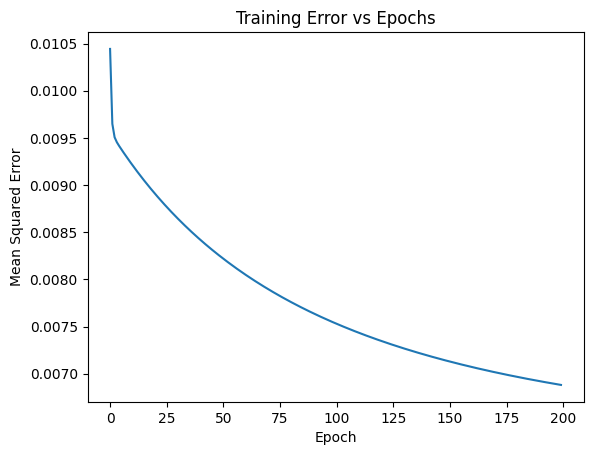

In [17]:
import matplotlib.pyplot as plt

# Training samples (x, y) from the assignment
samples = [
    (3.0, 0.7312),
    (2.0, 0.7339),
    (1.5, 0.7438),
    (1.0, 0.7832),
    (0.5, 0.8903),
    (0.0, 0.9820),
    (0.5, 0.8114),
    (1.0, 0.5937),
    (1.5, 0.5219),
    (2.0, 0.5049),
    (3.0, 0.5002),
]

def mse_loss(y_true, y_pred):
    return 0.5 * (y_pred - y_true) ** 2

def train_sgd(samples, weights, learning_rate=0.1, epochs=100):
    errors = []
    for _ in range(epochs):
        epoch_error = 0.0
        for x, y in samples:
            out = forward_pass(x, weights)
            a, z = out["a"], out["z"]
            y_pred = z[4]
            epoch_error += mse_loss(y, y_pred)

            d = backward_pass(a, z, y, weights)
            for (to_i, from_j), w in list(weights.items()):
                grad = d[to_i - 1] * z[from_j - 1]
                weights[(to_i, from_j)] -= learning_rate * grad
        errors.append(epoch_error / len(samples))
    return errors

# fixed weights from the assignment
weights_c = {
    # B = weight matrix B 
    (2,1): 3,    # B1 -> B2
    (3,1): -4,   # B1 -> B3
    (4,1): -1,   # B1 -> B4
    (3,2): 1,    # B2 -> B3
    (4,2): -3,   # B2 -> B4
    (5,3): 2,    # B3 -> B5
    (5,4): -10,  # B4 -> B5
}

# Train and get error history
errors = train_sgd(samples, weights_c, learning_rate=0.1, epochs=200)

# Plot training error vs epochs
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training Error vs Epochs")
plt.show()
